## 03_ETL

#### Scrapping programs

In [1]:
import re
import time
import unidecode
import pandas as pd
import geopandas as gpd
from lib import personalised_graphics
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

usa_cities = pd.read_csv("data/usa_cities.csv")
usa_states = pd.read_csv("data/usa_states.csv")

Cannot find header.dxf (GDAL_DATA is not defined)


Hotels

In [2]:
# This function takes a list of cities and returns a list of dicts with each hotel's data
def scrap_city_hotels(cities: list, state: str, report=True) -> list:
    cities_hotels = [] # to store data while scrapping
    failed_cities = [] # to store errors while scrapping

    # Instanciate and configurate driver
    chrome_options = Options()
    #chrome_options.add_argument('--headless') # unables GUI
    chrome_options.add_argument('--disable-infobars') # unables images loading
    driver = webdriver.Chrome(options=chrome_options)

    # Iterate over each city and scrape data into cities_hotels list
    for i, city in enumerate(cities):

        try:
            print(f'{i+1}/{len(cities)} - {city}')
            # Connect to url and wait to load
            counter = 0
            driver.get(f"https://www.booking.com/searchresults.es.html?ss={city}&ssne={city}&ssne_untouched={city}&label=bin859jc-1DCAMo7AE4mgNIClgDaAyIAQGYAQq4ARfIAQzYAQPoAQH4AQKIAgGoAgO4AtamjqsGwAIB0gIkNjY3NWU0MzUtZDQ2Yy00MGI3LWE3M2ItYzQ5YTQ3YmJhY2M52AIE4AIB&sid=867675c0a6ac4ae450c754b639211fc5&aid=357028&lang=es&sb=1&src_elem=sb&src=searchresults&dest_id={city}&dest_type=city&checkin=2024-05-12&checkout=2024-05-18&group_adults=2&no_rooms=1&group_children=0&offset={counter}")
            time.sleep(5)
            # WARNING this part is not working, the pop-up card must be closed manually
            #close pop-up card 
            #boton = driver.find_element(By.XPATH, '//*[@id="b2searchresultsPage"]/div[44]/div/div/div/div[1]/div[1]/div/button')
            #boton.click()
            # Find amount of pages for the city
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight*0.85);") # scroll to load page and buttons
            pages = driver.find_elements(By.CLASS_NAME, "b16a89683f") # find list of pages
            n_pages = int(pages[len(pages)-2].text) # read last page button

            # Iterate over each page to scrape data
            for page in range(n_pages):
                # Find each hotel box
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight*0.85);") # scroll to load page and buttons
                wait = WebDriverWait(driver, 10) # 
                hotel_divs = wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, "c82435a4b8"))) # find each hotel box
                # Iterar over each box to scrape name, price, average score and url
                for div in hotel_divs: 
                    try:
                        # Find data
                        name_and_price_elements = div.find_elements(By.CLASS_NAME, "f6431b446c") # find name and price
                        url_element = div.find_element(By.CLASS_NAME, "a78ca197d0") # find url
                        score_element = div.find_element(By.CLASS_NAME, "a3b8729ab1") # find avg_score
                        # Store data in cities_hotels list
                        if len(name_and_price_elements) == 2 and url_element and score_element: 
                            name = name_and_price_elements[0].text
                            price = name_and_price_elements[1].text
                            url = url_element.get_attribute('href')
                            avg_score = score_element.text
                            cities_hotels.append({"state": state, "city": city,"name": name, "avg_score": avg_score, "price": price, "reviews_url": url})
                    except Exception as e:
                        pass
                if report:
                    print(f"    Pagina {page+1}/{n_pages} scrapped - {len(cities_hotels)} total hotels finded.") # Console report
                # Go to next page if not last page
                if page+1 < n_pages:
                    if page+1 == 2: # Handle error
                        counter += 25
                        driver.get(f"https://www.booking.com/searchresults.es.html?ss={city}&ssne={city}&ssne_untouched={city}&label=bin859jc-1DCAMo7AE4mgNIClgDaAyIAQGYAQq4ARfIAQzYAQPoAQH4AQKIAgGoAgO4AtamjqsGwAIB0gIkNjY3NWU0MzUtZDQ2Yy00MGI3LWE3M2ItYzQ5YTQ3YmJhY2M52AIE4AIB&sid=867675c0a6ac4ae450c754b639211fc5&aid=357028&lang=es&sb=1&src_elem=sb&src=searchresults&dest_id={city}&dest_type=city&checkin=2024-05-12&checkout=2024-05-18&group_adults=2&no_rooms=1&group_children=0&offset={counter}")
                    else: 
                        buttons = driver.find_elements(By.CLASS_NAME, "b16a89683f") # find list of pages
                        buttons[len(buttons)-1].click() # click last page button

        except:
            failed_cities.append(city)
            if report:
                print(f"{city} city added to failed cities.") # Console report

    # Close browser and return list with hotels data
    driver.quit()
    return cities_hotels

# Example
#data = pd.DataFrame(scrap_city_hotels(["New York" ,"Los Angeles"], state="CA"))
#data.to_csv('California.csv', index=False)
#data

Hotels attributes

In [69]:
def scrap_hotels_attributes(urls):

    hotels_attributes = pd.DataFrame()

    # Instanciate and configurate driver
    chrome_options = Options()
    # chrome_options.add_argument('--headless') # unables GUI
    chrome_options.add_argument('--disable-infobars') # unables images loading
    chrome_options.add_argument('--blink-settings=imagesEnabled=false')  # deshabilita carga de imágenes
    driver = webdriver.Chrome(options=chrome_options)
    
    for i, url in enumerate(urls):

        driver.get(url)
        print(f"{i+1}/{len(urls)}")

        """# Obtener dirección
        try:
            direccion_element = driver.find_element(By.CLASS_NAME, "hp_address_subtitle")
            direccion_texto = direccion_element.text
        except:
            direccion_texto = None"""

        """# Obtener descripción
        try:
            descripcion_element = driver.find_element(By.CLASS_NAME, "b3efd73f69")
            descripcion_texto = descripcion_element.text
        except:
            descripcion_texto = None"""

        
        try: # Obtener atributos
            list_items = driver.find_elements(By.XPATH, "/html/body/div[3]/div/div[5]/div[1]/div[1]/div[3]/div/div/div[1]/div[2]/div[2]/div/div/ul/li")
            attributes_list = [li.text for li in list_items]
        except:
            attributes_list = None

        
        try: # Obtener latitud y longitud
            map_element = driver.find_element(By.ID, 'hotel_sidebar_static_map')
            lat_lng_attribute = map_element.get_attribute('data-atlas-latlng')
            lat, lng = map(float, lat_lng_attribute.split(','))
        except:
            lat, lng = None, None

        try: # Scores
            score_list = []
            wait = WebDriverWait(driver, 10)
            scores = wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'ccb65902b2')))
            #scores = driver.find_elements
            for i, score in enumerate(scores):
                s = score.text
                try:
                    if s[0].isdigit():
                        print(scores[i-1].text)
                        print(s)
                        score_list.append({f"{scores[i-1].text}": s})
                except:
                    pass
        except:
            score_list = None

        # Crear el DataFrame
        attributes = pd.DataFrame({
            #"Dirección": [direccion_texto],
            #"Descripción": [descripcion_texto],
            "reviews_url": [url],
            "atributos": [attributes_list],
            "latitud": [lat],
            "longitud": [lng],
            "scores": [score_list]
        })

        hotels_attributes = pd.concat([hotels_attributes, attributes], ignore_index=True)

    driver.quit()
    return hotels_attributes

# Example
utah_hotels = pd.read_csv("data/booking/raw_utah_hotels.csv")
utah_hotels_attributes = scrap_hotels_attributes(utah_hotels["reviews_url"].head(2).tolist())
utah_hotels_attributes

1/2
Personal
8,8
Instalaciones y servicios
8,5
Limpieza
8,8
Confort
8,7
Relación calidad-precio
8,0
Ubicación
9,0
WiFi gratis
8,1
2/2
Personal
9,3
Instalaciones y servicios
9,3
Limpieza
9,6
Confort
9,5
Relación calidad-precio
8,6
Ubicación
9,5
WiFi gratis
9,3


,reviews_url,atributos,latitud,longitud,scores
0,https://www.booking.com/hotel/us/little-americ...,[],40.758264,-111.891465,"[{'Personal': '8,8'}, {'Instalaciones y servic..."
1,https://www.booking.com/hotel/us/hyatt-regency...,"[Piscina al aire libre, Habitaciones sin humo,...",40.766077,-111.894710,"[{'Personal': '9,3'}, {'Instalaciones y servic..."


In [5]:
utah_hotels_attributes

,reviews_url,atributos,latitud,longitud,scores
0,https://www.booking.com/hotel/us/little-americ...,[],40.758264,-111.891465,[]
1,https://www.booking.com/hotel/us/hyatt-regency...,"[Piscina al aire libre, Parking en el alojamie...",40.766077,-111.894710,[]


Attractions

In [22]:
# This function takes a state and the corresponding url and returns a list of dicts with each state's touristic attractions
def scrap_state_attractions(state: str, url: str, report=True) -> list:
    states_attractions = [] # to store data while scrapping
    failed_states = [] # to store errors while scrapping

    # Instanciate and configurate driver
    chrome_options = Options()
    #chrome_options.add_argument('--headless') # unables GUI
    chrome_options.add_argument('--disable-infobars') # unables images loading
    driver = webdriver.Chrome(options=chrome_options)

    # Connect to url and wait to load
    driver.get(url)
    time.sleep(5)

    # Find amount of pages for the city
    try:

        for _ in range(10):
            # Find each attraction box
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight*0.85);") # scroll to load page and buttons
            wait = WebDriverWait(driver, 10) # 
            attraction_divs = wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, "jemSU"))) # find each attraction box

            for div in attraction_divs:
                try:
                    url = div.find_element(By.CLASS_NAME ,"BMQDV")
                    parts = div.text.split("\n")
                    if 15 > len(parts) > 2 and url:
                        if parts[0] == '2023':
                            del parts[0]
                            states_attractions.append({"state_id": usa_states[usa_states["state"] == "California"]["state_id"].iloc[0], "attraction": parts[0], "categories": parts[2], "reviews_url": url.get_attribute('href')})
                except:
                    pass

            next_page_button = driver.find_element(By.XPATH, '/html/body/div[1]/main/div[1]/div/div/div[3]/div/div[2]/div[2]/div[2]/div/div/div[2]/div/div[2]/div/div/section[40]/div/div[1]/div/div[1]/div[2]')
            next_page_button.click()
            
    except:
        failed_states.append(state)
        if report:
            print(f"{state} state added to failed states.") # Console report

    # Close browser and return list with hotels data
    driver.quit()
    return states_attractions

# Example
#url = "https://www.tripadvisor.com.ar/Attractions-g28926-Activities-a_allAttractions.true-California.html"
#data = pd.DataFrame(scrap_state_attractions("California", url))
#data.to_csv('California_attractions.csv', index=False)

#data

Attractions atributes

In [23]:
# This function takes a state and the corresponding url and returns a list of dicts with each state's touristic attractions
def scrap_attractions_attribute(urls: str, report=True) -> list:
    attributes = [] # to store data while scrapping
    failed_urls = [] # to store errors while scrapping

    # Instanciate and configurate driver
    chrome_options = Options()
    chrome_options.add_argument('--headless') # unables GUI
    chrome_options.add_argument('--disable-infobars') # unables images loading
    driver = webdriver.Chrome(options=chrome_options)

    for i, url in enumerate(urls):
        print(f'{i+1}/{len(urls)}')
        try:         
            # 
            driver.get(url)
            time.sleep(5)
            #
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight*0.85);") # scroll to load page and buttons
            path_element = driver.find_element(By.CLASS_NAME, 'oPZZx')
            html = path_element.get_attribute("outerHTML")
            matches = re.search(r'center=([\d.-]+),([\d.-]+)', html)
            #
            if matches:
                attributes.append({"url": url, "latitud": matches.group(1), "longitude": matches.group(2)})
            else:
                attributes.append({"url": url, "latitud": matches.group(1), "longitude": matches.group(2)})
                
        except:
            attributes.append({"url": url, "latitud": None, "longitude": None})

    return attributes

# Example
#utah_attractions = pd.read_csv("data/etl/raw_Utah_attractions.csv")
#urls = utah_attractions["reviews_url"].tolist()
#data = pd.DataFrame(scrap_attractions_attribute(urls))
#data.to_csv('hotel_attributes.csv', index=False)

#data

##### Utah

hotels

###### 4m 18s

In [4]:
# Scrape hotels
utah_cities = usa_cities[(usa_cities["state_id"] == "UT") & (usa_cities["population"] > 100000)].sort_values(by="population", ascending=False)
raw_utah_hotels = pd.DataFrame(scrap_city_hotels(utah_cities["city"].to_list(), state="UT"))

# Transform scrapped data
utah_hotels = raw_utah_hotels.dropna(subset=['reviews_url'])

# Process avg_score
utah_hotels['avg_score'] = utah_hotels['avg_score'].replace(',', '.')
utah_hotels['avg_score'] = utah_hotels['avg_score'].replace('[^\d.]', '', regex=True)
utah_hotels['avg_score'] = utah_hotels['avg_score'].astype(float)

# Process price
for i, row in utah_hotels.iterrows():
    price = row['price']
    price = price.replace('$', '')
    price = price.replace(' ', '')
    if price.count(".") == 1:
        utah_hotels.at[i, 'price'] = price
    elif price.count(".") == 2:
        first_dot_index = price.find('.')
        utah_hotels.at[i, 'price'] = price[:first_dot_index] + price[first_dot_index+1:]
    else:
        print(price)
utah_hotels['price'] = pd.to_numeric(utah_hotels['price'], errors='coerce')

utah_hotels.to_csv('data/booking/utah_hotels.csv', index=False)
utah_hotels

1/7 - Salt Lake City
    Pagina 1/7 scrapped - 25 total hotels finded.
    Pagina 2/7 scrapped - 44 total hotels finded.
    Pagina 3/7 scrapped - 69 total hotels finded.
    Pagina 4/7 scrapped - 89 total hotels finded.
    Pagina 5/7 scrapped - 108 total hotels finded.
    Pagina 6/7 scrapped - 125 total hotels finded.
    Pagina 7/7 scrapped - 143 total hotels finded.
2/7 - Ogden
    Pagina 1/2 scrapped - 166 total hotels finded.
    Pagina 2/2 scrapped - 177 total hotels finded.
3/7 - Provo
    Pagina 1/4 scrapped - 200 total hotels finded.
    Pagina 2/4 scrapped - 215 total hotels finded.
    Pagina 3/4 scrapped - 239 total hotels finded.
    Pagina 4/4 scrapped - 257 total hotels finded.
4/7 - St. George
    Pagina 1/13 scrapped - 282 total hotels finded.
    Pagina 2/13 scrapped - 306 total hotels finded.
    Pagina 3/13 scrapped - 328 total hotels finded.
    Pagina 4/13 scrapped - 348 total hotels finded.
    Pagina 5/13 scrapped - 368 total hotels finded.
    Pagina 6/13 scr

###### 110m 28s

In [70]:
# scrape hotels attributes
raw_utah_hotels = pd.read_csv("data/booking/raw_utah_hotels.csv")
utah_data_hotels_attributes = scrap_hotels_attributes(raw_utah_hotels["reviews_url"].tolist())
utah_data_hotels_attributes.to_csv('data/booking/raw_utah_hotels_attributes.csv', index=False)

1/1113
Personal
8,8
Instalaciones y servicios
8,5
Limpieza
8,8
Confort
8,7
Relación calidad-precio
8,0
Ubicación
9,0
WiFi gratis
8,1
2/1113
Personal
9,3
Instalaciones y servicios
9,3
Limpieza
9,6
Confort
9,5
Relación calidad-precio
8,6
Ubicación
9,5
WiFi gratis
9,3
3/1113
Personal
8,8
Instalaciones y servicios
8,7
Limpieza
8,9
Confort
9,0
Relación calidad-precio
8,4
Ubicación
9,2
WiFi gratis
8,7
4/1113
Personal
8,5
Instalaciones y servicios
7,9
Limpieza
8,4
Confort
8,3
Relación calidad-precio
7,4
Ubicación
9,2
5/1113
Personal
8,8
Instalaciones y servicios
8,8
Limpieza
9,0
Confort
9,0
Relación calidad-precio
8,5
Ubicación
8,2
WiFi gratis
8,8
6/1113
Personal
8,6
Instalaciones y servicios
8,1
Limpieza
8,4
Confort
8,5
Relación calidad-precio
8,3
Ubicación
9,3
WiFi gratis
7,5
7/1113
Personal
7,9
Instalaciones y servicios
6,8
Limpieza
7,3
Confort
7,3
Relación calidad-precio
7,0
Ubicación
8,0
WiFi gratis
7,2
8/1113
Personal
8,4
Instalaciones y servicios
7,7
Limpieza
8,3
Confort
8,3
Relación c

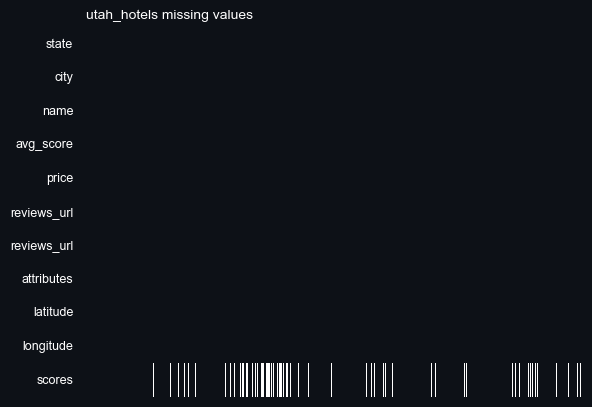

,state,city,name,avg_score,price,reviews_url,reviews_url,attributes,latitude,longitude,scores
0,UT,Salt Lake City,Little America Hotel Salt Lake City,82.0,364.010,https://www.booking.com/hotel/us/little-americ...,https://www.booking.com/hotel/us/little-americ...,[],40.758264,-111.891465,"[{'Personal': '8,8'}, {'Instalaciones y servic..."
1,UT,Salt Lake City,Hyatt Regency Salt Lake City,90.0,645.928,https://www.booking.com/hotel/us/hyatt-regency...,https://www.booking.com/hotel/us/hyatt-regency...,"['Piscina al aire libre', 'Habitaciones sin hu...",40.766077,-111.894710,"[{'Personal': '9,3'}, {'Instalaciones y servic..."
2,UT,Salt Lake City,"Holiday Inn Express Salt Lake City Downtown, a...",84.0,444.952,https://www.booking.com/hotel/us/shilo-inn-sal...,https://www.booking.com/hotel/us/shilo-inn-sal...,[],40.764598,-111.893959,"[{'Personal': '8,8'}, {'Instalaciones y servic..."
3,UT,Salt Lake City,Salt Lake Marriott Downtown at City Creek,77.0,604.126,https://www.booking.com/hotel/us/salt-lake-cit...,https://www.booking.com/hotel/us/salt-lake-cit...,[],40.767572,-111.893578,"[{'Personal': '8,5'}, {'Instalaciones y servic..."
4,UT,Salt Lake City,Homewood Suites by Hilton Salt Lake City Downtown,85.0,452.711,https://www.booking.com/hotel/us/homewood-suit...,https://www.booking.com/hotel/us/homewood-suit...,[],40.762626,-111.903379,"[{'Personal': '8,8'}, {'Instalaciones y servic..."
...,...,...,...,...,...,...,...,...,...,...,...
1108,UT,West Jordan,"Capitol Retreats-views! Near Salt Palace,sleep 28",95.0,790.848,https://www.booking.com/hotel/us/city-views-ne...,https://www.booking.com/hotel/us/city-views-ne...,[],40.783652,-111.889577,NaN
1109,UT,West Jordan,King BD - City View - Downtown Walking Heaven,10.0,299.201,https://www.booking.com/hotel/us/king-bd-city-...,https://www.booking.com/hotel/us/king-bd-city-...,[],40.760921,-111.877099,"[{'Personal': '10'}, {'Instalaciones y servici..."
1110,UT,West Jordan,Downtown Condo Near the Convention Center,79.0,489.415,https://www.booking.com/hotel/us/downtown-cond...,https://www.booking.com/hotel/us/downtown-cond...,[],40.769836,-111.910589,"[{'Personal': '7,9'}, {'Instalaciones y servic..."
1111,UT,West Jordan,Cozy for Bookworms - Laundry - King Bed - Parking,87.0,271.477,https://www.booking.com/hotel/us/cozy-for-book...,https://www.booking.com/hotel/us/cozy-for-book...,"['WiFi gratis', 'Parking gratis']",40.781976,-111.896490,"[{'Personal': '9,4'}, {'Instalaciones y servic..."


In [72]:
# Import previosuly scrapped
utah_hotels = pd.read_csv("data/booking/utah_hotels.csv")
raw_utah_hotels_attributes = pd.read_csv("data/booking/raw_utah_hotels_attributes.csv")

# join hotels and attributes
utah_hotels_attributes = raw_utah_hotels_attributes.rename(columns={"atributos": "attributes", "latitud": "latitude", "longitud": "longitude"})
utah_hotels = pd.concat([utah_hotels, utah_hotels_attributes], axis=1)

# Explore and export
personalised_graphics.missing_values_heatmap(utah_hotels, "utah_hotels")
utah_hotels.to_csv('data/booking_utah_hotels.csv', index=False)
utah_hotels

Attractions

In [39]:
# Scrape attractions
url = "https://www.tripadvisor.com.ar/Attractions-g28965-Activities-a_allAttractions.true-Utah.html"
raw_utah_attractions = pd.DataFrame(scrap_state_attractions("Utah", url))

# Transform
utah_attractions = raw_utah_attractions.copy()
utah_attractions['attraction'] = utah_attractions['attraction'].str.replace(r'^\d+\.\s*', '', regex=True) # Process attraction
utah_attractions['categories'] = utah_attractions['categories'].str.replace(' • ', ', ') # Process categories
utah_attractions

,state_id,attraction,categories,reviews_url
0,CA,Bryce Canyon National Park,Formaciones geológicas,https://www.tripadvisor.com.ar/Attraction_Revi...
1,CA,Arches National Park,"Parques nacionales, Rutas para senderismo",https://www.tripadvisor.com.ar/Attraction_Revi...
2,CA,Monument Valley Navajo Tribal Park,"Monumentos y lugares de interés, Formaciones g...",https://www.tripadvisor.com.ar/Attraction_Revi...
3,CA,The Narrows,"Parques nacionales, Rutas para senderismo",https://www.tripadvisor.com.ar/Attraction_Revi...
4,CA,Dead Horse Point State Park,Parques estatales,https://www.tripadvisor.com.ar/Attraction_Revi...
5,CA,Angel's Landing,Rutas para senderismo,https://www.tripadvisor.com.ar/Attraction_Revi...
6,CA,Zion National Park,Parques nacionales,https://www.tripadvisor.com.ar/Attraction_Revi...
7,CA,Canyonlands National Park,"Montañas, Parques nacionales",https://www.tripadvisor.com.ar/Attraction_Revi...
8,CA,Zion Canyon Scenic Drive,Rutas turísticas,https://www.tripadvisor.com.ar/Attraction_Revi...
9,CA,Navajo/Queens Garden Loop,Rutas para senderismo,https://www.tripadvisor.com.ar/Attraction_Revi...


In [40]:
# scrape attractions attributes
utah_attractions = pd.read_csv("data/booking/raw_utah_attractions.csv")
urls = utah_attractions["reviews_url"].tolist()
utah_attractions_atributes = pd.DataFrame(scrap_attractions_attribute(urls))
utah_attractions_atributes

1/59
2/59
3/59
4/59
5/59
6/59
7/59
8/59
9/59
10/59
11/59
12/59
13/59
14/59
15/59
16/59
17/59
18/59
19/59
20/59
21/59
22/59
23/59
24/59
25/59
26/59
27/59
28/59
29/59
30/59
31/59
32/59
33/59
34/59
35/59
36/59
37/59
38/59
39/59
40/59
41/59
42/59
43/59
44/59
45/59
46/59
47/59
48/59
49/59
50/59
51/59
52/59
53/59
54/59
55/59
56/59
57/59
58/59
59/59


,url,latitud,longitude
0,https://www.tripadvisor.com.ar/Attraction_Revi...,37.622334,-112.168831
1,https://www.tripadvisor.com.ar/Attraction_Revi...,38.743706,-109.559563
2,https://www.tripadvisor.com.ar/Attraction_Revi...,36.996433,-110.098251
3,https://www.tripadvisor.com.ar/Attraction_Revi...,37.190338,-112.995193
4,https://www.tripadvisor.com.ar/Attraction_Revi...,38.484482,-109.738388
5,https://www.tripadvisor.com.ar/Attraction_Revi...,37.300362,-112.991028
6,https://www.tripadvisor.com.ar/Attraction_Revi...,37.301121,-113.003189
7,https://www.tripadvisor.com.ar/Attraction_Revi...,38.388023,-109.863510
8,https://www.tripadvisor.com.ar/Attraction_Revi...,37.234028,-112.954498
9,https://www.tripadvisor.com.ar/Attraction_Revi...,37.625637,-112.160027


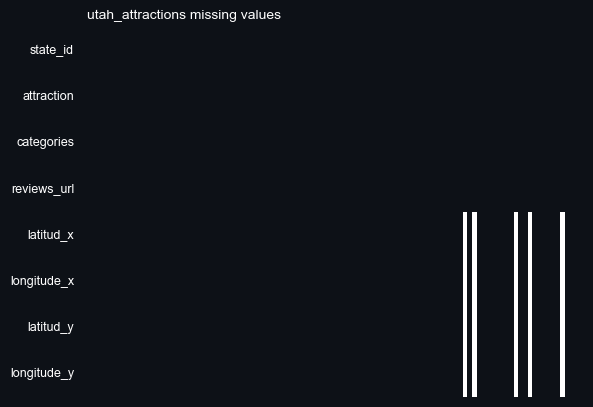

In [42]:
# Combine attractions with attributes
utah_attractions_atributes.rename(columns={"url": "reviews_url"}, inplace=True)
utah_attractions = pd.merge(utah_attractions, utah_attractions_atributes, on="reviews_url")
# Explore and export
personalised_graphics.missing_values_heatmap(utah_attractions, "utah_attractions")
utah_attractions.to_csv('data/utah_attractions.csv', index=False)